In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *
from deep_learning import *

Using TensorFlow backend.


### Load Annotated Data

In [2]:
task = 'aggression'
xtype = 'ngams'
ytype = 'empirical_dist'
n_classes = 3
annotations = load_annotations()

time: 26.2 s


In [3]:
data = label_and_split(annotations, task)

time: 2min 4s


### NGram Preprocessing

In [4]:
feature_pipeline =  Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('to_dense', DenseTransformer()), 
])

X_comments, _ = assemble_data(data, 'comments', ytype, splits = ['train'])
preprocessor = feature_pipeline.fit(X_comments)
data = apply_transform(data, 'comments', preprocessor, xtype)

X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 5min 59s


### Define Model

In [5]:
clf =  KerasClassifier(build_fn=make_MLP, output_dim = n_classes, input_dim = 10000)

time: 3.88 ms


### Deep EDP Hyper-Parameter tuning

In [7]:
# Deep EDP

param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (1,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
30370/30370 [==============================] - 9s     
Epoch 1/1
30370/30370 [==============================] - 10s    
Epoch 1/1
30370/30370 [==============================] - 13s    
Epoch 1/1
30370/30370 [==============================] - 11s    

Best parameters set found:
{'layers': [50, 10], 'nb_epoch': 1, 'l': 0, 'batch_size': 100} 0.932869096682


Grid scores:
0.93287 (+/-0.00000) for {'layers': [50, 10], 'nb_epoch': 1, 'l': 0, 'batch_size': 100}
0.93027 (+/-0.00000) for {'layers': [50, 10], 'nb_epoch': 1, 'l': 1e-05, 'batch_size': 100}
0.92827 (+/-0.00000) for {'layers': [50, 10], 'nb_epoch': 1, 'l': 0.0001, 'batch_size': 100}
0.83889 (+/-0.00000) for {'layers': [50, 10], 'nb_epoch': 1, 'l': 0.001, 'batch_size': 100}
time: 5min 50s


Seems, like we don't need to regularize at one epoch. Lets try more epochs.

In [6]:
# Deep EDP
param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (2,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/2
70862/70862 [==============================] - 30s - loss: 0.1633 - acc: 0.8718    
Epoch 2/2
30370/30370 [==============================] - 7s     
Epoch 1/2
70862/70862 [==============================] - 31s - loss: 0.1772 - acc: 0.8678    
Epoch 2/2
30370/30370 [==============================] - 7s     
Epoch 1/2
70862/70862 [==============================] - 31s - loss: 0.1940 - acc: 0.8646    
Epoch 2/2
30370/30370 [==============================] - 7s     
Epoch 1/2
70862/70862 [==============================] - 34s - loss: 0.3022 - acc: 0.8259    
Epoch 2/2
30370/30370 [==============================] - 7s     

Best parameters set found:
{'layers': [50, 10], 'batch_size': 100, 'l': 0, 'nb_epoch': 2} 0.939473574479


Grid scores:
0.93947 (+/-0.00000) for {'layers': [50, 10], 'batch_size': 100, 'l': 0, 'nb_epoch': 2}
0.93650 (+/-0.00000) for {'layers': [50, 10], 'batch_size': 100, 'l': 1e-05, 'nb_epoch': 2}
0.93515 (+/-0.00000) for {'layers': [50, 10], 'batch_size': 100

Same pattern. Results improved for lower reg. Lets try more epochs.

In [7]:
# Deep EDP
param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (4,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/4
70862/70862 [==============================] - 31s - loss: 0.1564 - acc: 0.8728    
Epoch 2/4
70862/70862 [==============================] - 26s - loss: 0.0977 - acc: 0.9038    
Epoch 3/4
70862/70862 [==============================] - 26s - loss: 0.0911 - acc: 0.9093    
Epoch 4/4
30370/30370 [==============================] - 6s     
Epoch 1/4
70862/70862 [==============================] - 30s - loss: 0.1714 - acc: 0.8728    
Epoch 2/4
70862/70862 [==============================] - 26s - loss: 0.1085 - acc: 0.9014    
Epoch 3/4
70862/70862 [==============================] - 26s - loss: 0.1029 - acc: 0.9055    
Epoch 4/4
30370/30370 [==============================] - 7s     
Epoch 1/4
70862/70862 [==============================] - 32s - loss: 0.1936 - acc: 0.8678    
Epoch 2/4
70862/70862 [==============================] - 25s - loss: 0.1234 - acc: 0.8965    
Epoch 3/4
70862/70862 [==============================] - 26s - loss: 0.1186 - acc: 0.8999    
Epoch 4/4
30370/30370 [=

Same pattern still, although performance has plateaued.

Right now, 4 epochs and no regularization is best. Lets add more layers.

In [8]:
# Deep EDP
param_grid = {
    'l': (0.000001,),
    'nb_epoch' : (2,),
    'batch_size': (100,),
    'layers': ([50, 50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/2
70862/70862 [==============================] - 32s - loss: 0.1656 - acc: 0.8699    
Epoch 2/2
30370/30370 [==============================] - 8s     

Best parameters set found:
{'layers': [50, 50, 10], 'batch_size': 100, 'l': 1e-06, 'nb_epoch': 2} 0.939518090435


Grid scores:
0.93952 (+/-0.00000) for {'layers': [50, 50, 10], 'batch_size': 100, 'l': 1e-06, 'nb_epoch': 2}
time: 1min 25s


Adding more layers did not help.

### Linear EDP Tuning

In [9]:
# Linear EDP
param_grid = {
    'l': (0,),
    'nb_epoch' : (1,2,4,8,16),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
30370/30370 [==============================] - 4s     
Epoch 1/2
70862/70862 [==============================] - 14s - loss: 0.1899 - acc: 0.8543    
Epoch 2/2
30370/30370 [==============================] - 4s     
Epoch 1/4
70862/70862 [==============================] - 14s - loss: 0.1908 - acc: 0.8550    
Epoch 2/4
70862/70862 [==============================] - 9s - loss: 0.1254 - acc: 0.8812     
Epoch 3/4
70862/70862 [==============================] - 9s - loss: 0.1134 - acc: 0.8879     
Epoch 4/4
30370/30370 [==============================] - 4s     
Epoch 1/8
70862/70862 [==============================] - 15s - loss: 0.1920 - acc: 0.8543    
Epoch 2/8
70862/70862 [==============================] - 10s - loss: 0.1257 - acc: 0.8813    
Epoch 3/8
70862/70862 [==============================] - 10s - loss: 0.1136 - acc: 0.8884    
Epoch 4/8
70862/70862 [==============================] - 10s - loss: 0.1080 - acc: 0.8927    
Epoch 5/8
70862/70862 [==============================

We won't bother regularizing. Lets just tune epochs. Seems to max out at 8.

### Linear OH Tuning

In [10]:
# Linear OH
param_grid = {
    'l': (0,),
    'nb_epoch' : (1,2,4,8,16),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, one_hot(y_train), clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
30370/30370 [==============================] - 5s     
Epoch 1/2
70862/70862 [==============================] - 15s - loss: 0.4696 - acc: 0.8471    
Epoch 2/2
30370/30370 [==============================] - 4s     
Epoch 1/4
70862/70862 [==============================] - 13s - loss: 0.4645 - acc: 0.8475    
Epoch 2/4
70862/70862 [==============================] - 8s - loss: 0.3436 - acc: 0.8782     
Epoch 3/4
70862/70862 [==============================] - 8s - loss: 0.3080 - acc: 0.8868     
Epoch 4/4
30370/30370 [==============================] - 4s     
Epoch 1/8
70862/70862 [==============================] - 13s - loss: 0.4683 - acc: 0.8466    
Epoch 2/8
70862/70862 [==============================] - 8s - loss: 0.3449 - acc: 0.8779     
Epoch 3/8
70862/70862 [==============================] - 8s - loss: 0.3092 - acc: 0.8865     
Epoch 4/8
70862/70862 [==============================] - 8s - loss: 0.2894 - acc: 0.8918     
Epoch 5/8
70862/70862 [==============================

Lets try more epochs.

In [11]:
param_grid = {
    'l': (0,),
    'nb_epoch' : (24, 32),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, one_hot(y_train), clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/24
70862/70862 [==============================] - 13s - loss: 0.4653 - acc: 0.8472    
Epoch 2/24
70862/70862 [==============================] - 8s - loss: 0.3447 - acc: 0.8779     
Epoch 3/24
70862/70862 [==============================] - 8s - loss: 0.3091 - acc: 0.8865     
Epoch 4/24
70862/70862 [==============================] - 9s - loss: 0.2893 - acc: 0.8915     
Epoch 5/24
70862/70862 [==============================] - 10s - loss: 0.2759 - acc: 0.8956    
Epoch 6/24
70862/70862 [==============================] - 10s - loss: 0.2661 - acc: 0.8985    
Epoch 7/24
70862/70862 [==============================] - 11s - loss: 0.2585 - acc: 0.9006    
Epoch 8/24
70862/70862 [==============================] - 9s - loss: 0.2523 - acc: 0.9031     
Epoch 9/24
70862/70862 [==============================] - 9s - loss: 0.2472 - acc: 0.9047     
Epoch 10/24
70862/70862 [==============================] - 9s - loss: 0.2429 - acc: 0.9060     
Epoch 11/24
70862/70862 [========================

### Eval SKlearn

In [12]:
sk_model = LogisticRegression(C = 5.0,  solver = 'sag')
sk_model.fit(X_train, y_train.argmax(axis = 1))
roc_df, spearman_df = test_cross(sk_model, data, xtype)

time: 6min 54s


In [13]:
roc_df

,random,blocked,both
user,0.915535,0.925286,0.932481
article,0.871340,0.924160,0.904776
both,0.917192,0.931547,0.935947


time: 15.3 ms


In [14]:
spearman_df

,random,blocked,both
user,0.570538,0.776069,0.768726
article,0.301367,0.534824,0.477323
both,0.459166,0.715595,0.679308


time: 5.26 ms


### Eval OH

In [15]:
oh_linear_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 24,
                               batch_size = 100,
                               l = 0.0, 
                               layers = [])
oh_linear_model.fit(X_train, one_hot(y_train))
roc_df, spearman_df = test_cross(oh_linear_model, data, xtype)

Epoch 1/24
101232/101232 [==============================] - 14s - loss: 0.4328 - acc: 0.8571    
Epoch 2/24
101232/101232 [==============================] - 12s - loss: 0.3206 - acc: 0.8844    
Epoch 3/24
101232/101232 [==============================] - 13s - loss: 0.2904 - acc: 0.8917    
Epoch 4/24
101232/101232 [==============================] - 14s - loss: 0.2737 - acc: 0.8962    
Epoch 5/24
101232/101232 [==============================] - 13s - loss: 0.2628 - acc: 0.8999    
Epoch 6/24
101232/101232 [==============================] - 12s - loss: 0.2549 - acc: 0.9026    
Epoch 7/24
101232/101232 [==============================] - 14s - loss: 0.2490 - acc: 0.9044    
Epoch 8/24
101232/101232 [==============================] - 12s - loss: 0.2442 - acc: 0.9065    
Epoch 9/24
101232/101232 [==============================] - 13s - loss: 0.2402 - acc: 0.9074    
Epoch 10/24
101232/101232 [==============================] - 13s - loss: 0.2369 - acc: 0.9086    
Epoch 11/24
101232/101232 [==

In [16]:
roc_df

,random,blocked,both
user,0.911594,0.922441,0.929645
article,0.869300,0.922832,0.902480
both,0.913600,0.928998,0.933363


time: 5.87 ms


In [17]:
spearman_df

,random,blocked,both
user,0.575097,0.772689,0.768268
article,0.301231,0.531035,0.475065
both,0.463567,0.712573,0.678883


time: 6.09 ms


### Eval Linear EDP

In [18]:
ed_linear_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 8,
                               batch_size = 100,
                               l = 0.0, 
                               layers = [])
ed_linear_model.fit(X_train, y_train)
roc_df, spearman_df = test_cross(ed_linear_model, data, xtype)

Epoch 1/8
101232/101232 [==============================] - 15s - loss: 0.1738 - acc: 0.8606    
Epoch 2/8
101232/101232 [==============================] - 12s - loss: 0.1175 - acc: 0.8864    
Epoch 3/8
101232/101232 [==============================] - 12s - loss: 0.1085 - acc: 0.8927    
Epoch 4/8
101232/101232 [==============================] - 12s - loss: 0.1043 - acc: 0.8955    
Epoch 5/8
101232/101232 [==============================] - 12s - loss: 0.1017 - acc: 0.8984    
Epoch 6/8
101232/101232 [==============================] - 12s - loss: 0.1000 - acc: 0.8998    
Epoch 7/8
101232/101232 [==============================] - 12s - loss: 0.0987 - acc: 0.9008    
Epoch 8/8
25310/25310 [==============================] - 2s     
time: 2min 13s


In [19]:
roc_df

,random,blocked,both
user,0.923065,0.927948,0.932993
article,0.889896,0.919314,0.910441
both,0.927002,0.934128,0.938158


time: 5.79 ms


In [20]:
spearman_df

,random,blocked,both
user,0.659160,0.788431,0.798242
article,0.375373,0.572697,0.526482
both,0.552194,0.736674,0.718135


time: 6.15 ms


### Eval Deep EDP

In [21]:
deep_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 4,
                               batch_size = 100,
                               l = 0.0000001, 
                               layers = [50, 10])
deep_model.fit(X_train, y_train)
roc_df, spearman_df = test_cross(deep_model, data, xtype)

Epoch 1/4
101232/101232 [==============================] - 32s - loss: 0.1508 - acc: 0.8748    
Epoch 2/4
101232/101232 [==============================] - 30s - loss: 0.0961 - acc: 0.9050    
Epoch 3/4
101232/101232 [==============================] - 31s - loss: 0.0902 - acc: 0.9115    
Epoch 4/4
25300/25310 [============================>.] - ETA: 0stime: 2min 44s


In [22]:
roc_df

,random,blocked,both
user,0.927201,0.935063,0.939174
article,0.893247,0.933452,0.921682
both,0.929819,0.941057,0.943983


time: 5.89 ms


In [23]:
spearman_df

,random,blocked,both
user,0.672777,0.804951,0.809583
article,0.393141,0.604627,0.552219
both,0.566397,0.755509,0.732789


time: 5.05 ms


### Check Calibration

25300/25310 [============================>.] - ETA: 0s

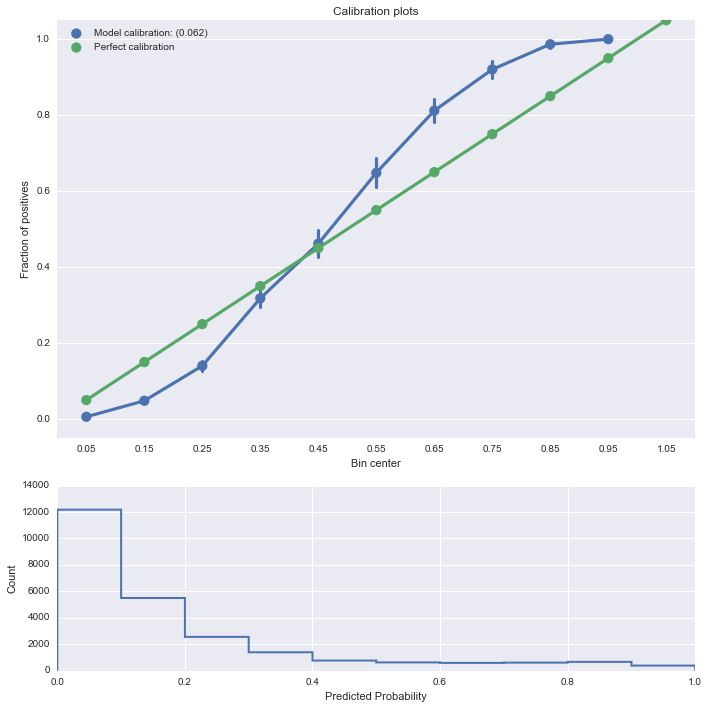

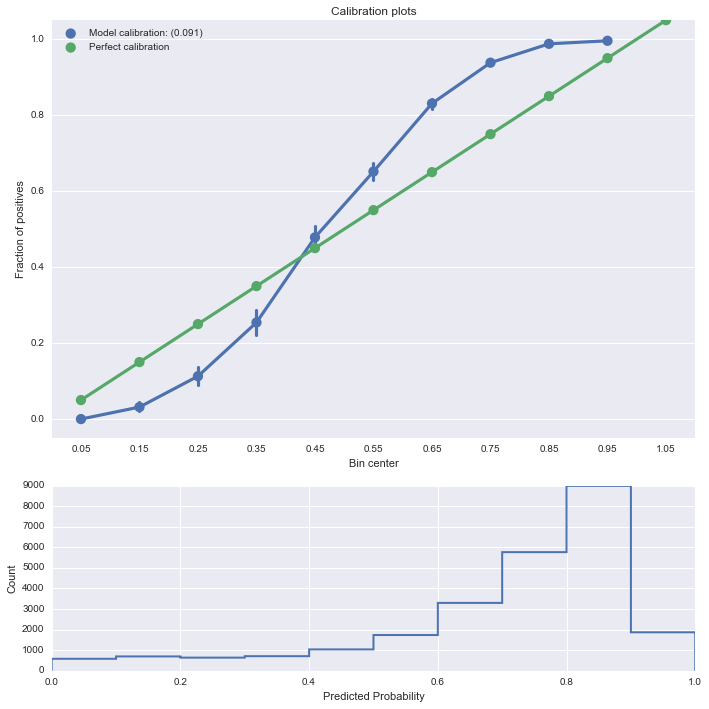

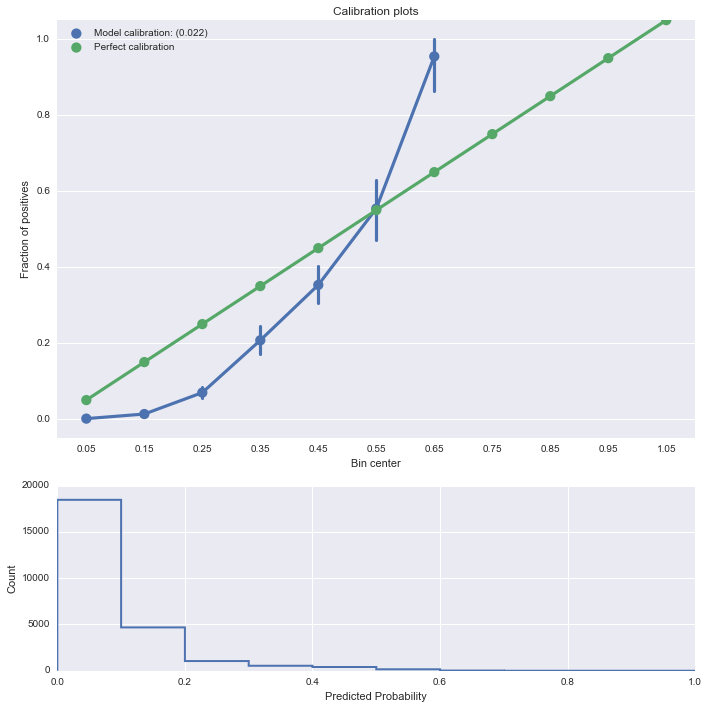

time: 8.94 s


In [24]:
y_test_oh = one_hot(y_test)
y_pred_ed = deep_model.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()